In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import re, string, unicodedata
import nltk
import contractions
import inflect

import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

import re

from wordcloud import WordCloud, STOPWORDS

import nltk
# import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer


from sklearn import metrics
from sklearn.model_selection import train_test_split
# from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder

import scipy

from gensim import corpora
from gensim import corpora
from gensim.similarities.docsim import Similarity
from gensim import corpora, models, similarities

import pickle
import time

# Read Train Split and Validation Data

In [2]:
rev_busi_Pho= pd.read_csv('../data/filtered_reviews_in_Phonex.csv', parse_dates=["date"])

train_df  = pickle.load(open('../data/train_df.pkl', "rb"))
valid_df = pickle.load(open('../data/valid_df.pkl', "rb"))
test_df = pickle.load(open('../data/test_df.pkl', "rb"))

In [3]:
train_df = train_df.merge(rev_busi_Pho[["review_id", "user_id", "business_id", "text"]], how = "left", on = ["user_id", "business_id"])
valid_df = valid_df.merge(rev_busi_Pho[["review_id", "user_id", "business_id", "text"]], how = "left", on = ["user_id", "business_id"])
test_df  = test_df.merge(rev_busi_Pho[["review_id", "user_id", "business_id", "text"]], how = "left", on = ["user_id", "business_id"])

train_df.head(1)

,user_id,business_id,stars,review_id,text
0,--2HUmLkcNHZp0xw6AMBPg,yX0pOWG_Be9TjGnm0aihVA,5.0,tfi5EOpqZw637p3AJtOUMg,Obsessed with their chicken salad and sweet fr...


In [4]:
train_df.shape
valid_df.shape
test_df.shape

(180559, 5)

(19500, 5)

(19500, 5)

In [5]:
print("unique users in training set:", train_df["user_id"].nunique())
print("unique businesses in training set:", train_df["business_id"].nunique())
print("unique users in test set:", test_df["user_id"].nunique())
print("unique businesses in test set:", test_df["business_id"].nunique())

unique users in training set: 19683
unique businesses in training set: 1728
unique users in test set: 19500
unique businesses in test set: 1672


# Content-based Model, NLP

### - Combine reviews of each business_id as its document 

In [6]:
train_df.head(1)
text_train_df = train_df.groupby(["business_id"])["text"].apply(lambda x: x.str.cat()).reset_index()
len(text_train_df)
text_train_df.head(1)

,user_id,business_id,stars,review_id,text
0,--2HUmLkcNHZp0xw6AMBPg,yX0pOWG_Be9TjGnm0aihVA,5.0,tfi5EOpqZw637p3AJtOUMg,Obsessed with their chicken salad and sweet fr...


1728

,business_id,text
0,-050d_XIor1NpCuWkbIVaQ,Great Food. Great Coffee. Great Service. Amazi...


### - Generate Wordcloud

In [7]:
# gather all words together
all_text = ""
all_snippets = text_train_df["text"].values

for snippet in all_snippets:
    all_text += snippet

# plot Wordcloud
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white',width=6000,height=6000).generate(all_text)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### - Text Prepocessing

In [6]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
            
    return new_words

def remove_special(words):
    """Remove special signs like &*"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[-,$()#+&*]', '', word)
        if new_word != '':
            new_words.append(new_word)
            
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
            
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""  
    stopwords = nltk.corpus.stopwords.words('english')
    myStopWords = []
    stopwords.extend(myStopWords)
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
            
    return new_words

def to_lowercase(words):
    """Convert words to lowercase"""
    new_words=[]
    for word in words:
        new_words.append(word.lower())
        
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stemmer = SnowballStemmer('english')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
        
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
        
    return lemmas

def normalize_lemmatize(words):
    words = remove_special(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    words = stem_words(words)
    words = lemmatize_verbs(words)
    
    return words


In [7]:
def get_processed(sample):
    processed = pd.DataFrame(data=[],columns = ['business_id', 'text'])
    new_texts = []

    for i in range(0, len(sample)):
        business_id = sample['business_id'].iloc[i]
        words = nltk.word_tokenize(sample['text'].iloc[i])
        text = ' '.join(normalize_lemmatize(words))
        dfnew = pd.DataFrame([[business_id, text]], columns=['business_id', 'text'])
        new_texts.append(text)
        processed = processed.append(dfnew,ignore_index = True)

    return processed


In [9]:
# This takes lots of time, 
# You may just read_pickle here after the initial run

# df_texts_train = get_processed(text_train_df)
# df_texts_train.to_pickle('../data/text_train_df.pkl')

df_texts_train = pickle.load(open('../data/text_train_df.pkl', "rb"))


### - Cosine Similarity

In [10]:
def get_tfidf_matrix(processed):
    '''
    get the Tf-Idf matrix of processed texts for business reviews
    
    '''
    TV = TfidfVectorizer(stop_words = "english")
    processed["text"] = processed["text"].fillna('')
    tfidf_matrix = TV.fit_transform((processed["text"]))
    
    return tfidf_matrix

def get_cos_sim_matrix(tfidf_matrix, n):
    '''
    use truncated SVD to reduce dimensions to n 
    @n: the dimensions to keep
    '''
    SVD = TruncatedSVD(n_components = n , random_state = 42) # 42 is the ultimate answer to everything
    tfidf_truncated = SVD.fit_transform(tfidf_matrix)
    cosine_sim = cosine_similarity(tfidf_truncated, tfidf_truncated)
    
    return cosine_sim


### - Dimension Reduction

<BarContainer object of 1727 artists>

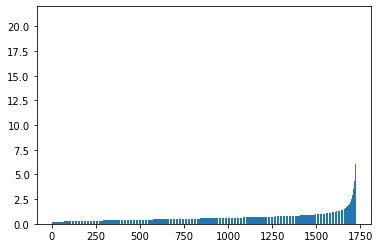

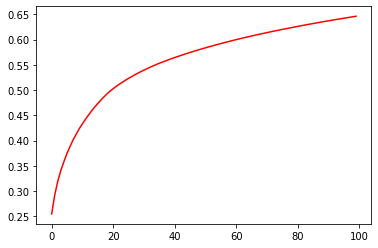

In [120]:
tfidf_matrix = get_tfidf_matrix(df_texts_train)
u, s, vt  = scipy.sparse.linalg.svds(tfidf_matrix, k = tfidf_matrix.shape[0]-1)
plt.bar(range(len(s)),s)
plt.show()

plt.plot(range(len(s))[:100], np.cumsum(sorted((s**2 / sum(s**2)),reverse = True)[:100]), "r" )
plt.show()

array([ 0.1161252 ,  0.1192119 ,  0.13759906, ...,  6.88350887,
        8.06597853, 20.98211441])

In [131]:
np.sort(s)[::-1]

array([20.98211441,  8.06597853,  6.88350887, ...,  0.13759906,
        0.1192119 ,  0.1161252 ])

<BarContainer object of 50 artists>

Text(0.5, 1.0, 'Singular values of restaurant features')

Text(0.5, 0, 'Dimension')

Text(0, 0.5, 'Singular values')

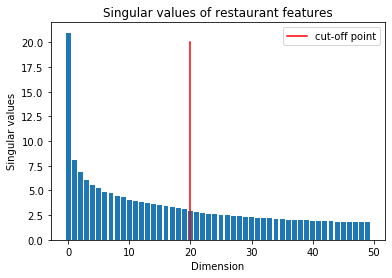

In [135]:
# u, s, vt  = np.linalg.svd(bus_df_subset.iloc[:,:])
plt.bar(range(50),np.sort(s)[::-1][:50])
plt.plot([20 for i in np.linspace(0,20,10)], np.linspace(0,20,10),"r", label = "cut-off point")
plt.title("Singular values of restaurant features")
plt.xlabel("Dimension")
plt.ylabel("Singular values")
plt.legend(loc = "best")
plt.show()

### - From plots above, here we choose n=20 as dimensions to keep

In [145]:
np.cumsum(np.sort(s)[::-1]**2/np.sum(np.sort(s)[::-1]**2))[:50]

array([0.25477565, 0.29242639, 0.31984713, 0.34098176, 0.35868284,
       0.37490348, 0.38859348, 0.40163766, 0.41279492, 0.42381338,
       0.43318138, 0.4422956 , 0.45075388, 0.45889689, 0.46643746,
       0.47343711, 0.48030357, 0.48657994, 0.49250794, 0.49798258,
       0.50274537, 0.50737858, 0.5116934 , 0.51570585, 0.51952977,
       0.52316857, 0.52670849, 0.53015597, 0.53340892, 0.53652741,
       0.53950106, 0.54240082, 0.54526104, 0.54802343, 0.55059968,
       0.5530765 , 0.55543922, 0.55772968, 0.56001719, 0.56224383,
       0.56444233, 0.56653124, 0.56860263, 0.57064209, 0.57260433,
       0.57454025, 0.57642692, 0.57830659, 0.58014366, 0.58192524])

Text(0.5, 1.0, 'Singular values of restaurant features')

Text(0.5, 0, 'Dimension')

Text(0, 0.5, 'Singular values')

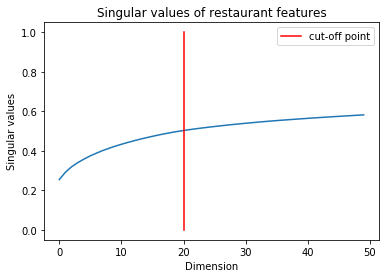

In [143]:
plt.plot(range(50), np.cumsum(np.sort(s)[::-1]**2/np.sum(np.sort(s)[::-1]**2))[:50] )
plt.plot([20 for i in np.linspace(0,1,10)], np.linspace(0,1,10),"r", label = "cut-off point")
plt.title("Singular values of restaurant features")
plt.xlabel("Dimension")
plt.ylabel("Singular values")
plt.legend(loc = "best")
plt.show()

In [11]:
tfidf_matrix = get_tfidf_matrix(df_texts_train)
cosine_sim = get_cos_sim_matrix(tfidf_matrix, 20)
df_sim = pd.DataFrame(cosine_sim, index=df_texts_train['business_id'].values, columns=df_texts_train['business_id'].values)
df_sim.head(1)
cosine_sim.shape

,-050d_XIor1NpCuWkbIVaQ,-0WegMt6Cy966qlDKhu6jA,-0tgMGl7D9B10YjSN2ujLA,-1UMR00eXtwaeh59pEiDjA,-45kMvS7h38CGaWugPY0rg,-8JaNeG3etLgOVyg2gOIiA,-9eNGMp8XiygI8t8QFuFWw,-A9sm-E6uQxWTJ_MuyOzFw,-Bdw-5H5C4AYSMGnAvmnzw,-BxWyEIQ6wypT-37MzZizQ,...,zSicVxnJHV8indit0oFuNw,zU63bs3Ofe8y1peOgOFJaA,zYZPpOqo_2YrLJLOmjlgPQ,zaBk2imYnk7rG7IdOMhRmA,zbrFk-4ejesAJD8EwcdHxg,zc1sur_MxkKkD6P8gYXQbg,zidkKI_N1OPxsiddTOQH_Q,znH36RmIAI4wcHy9WiEO5Q,zrTGcb83AsfyVTMrsCa65A,zwmps5SXn30g-f5wqg_r9A
-050d_XIor1NpCuWkbIVaQ,1.0,0.580148,0.577455,0.958394,0.691951,0.557193,0.649372,0.327343,0.719355,0.641419,...,0.969567,0.569617,0.38946,0.250388,0.529521,0.988208,0.342962,0.565981,0.662767,0.516715


(1728, 1728)

In [14]:
# plt.figure()
# plt.hist(cosine_sim.flatten(), bins = 100)
# plt.show()

In [12]:
def get_recommendation_cos(reviews, business_id, user_id, df_sim, k):
    '''get the business_id_array that shows top_k greatest similarity to the specific business_id'''
    user_bids = reviews[reviews['user_id']==user_id]['business_id'].values
    df_user = df_sim.loc[df_sim.index.isin(user_bids), df_sim.columns == business_id]
    df_user_topk = df_user.sort_values(df_user.columns[0], ascending = False).iloc[:k]
    
    return np.array(df_user_topk.index.values)


def predict_rating(reviews, user_id, business_ids):
    '''predict the avg of the user's rating on business in business_ids'''
    scores = reviews.loc[(reviews.user_id == user_id) & (reviews.business_id.isin(business_ids))]["stars"].values
    
    return np.mean(scores)


def get_results_cos(reviews, reviews_test, business_id, user_id, df_sim, k):
    '''
    prediction on the business_id：avg the ratings on top_k business that shows similarity to the business_id
    actual on the business_id: the true rating 
    '''
    actual = reviews_test.loc[(reviews_test.user_id==user_id) & (reviews_test.business_id==business_id)]['stars'].values[0]
    business_ids = get_recommendation_cos(reviews, business_id, user_id, df_sim, k)
    prediction = predict_rating(reviews, user_id, business_ids)
    
    return actual, prediction

def get_review_processed(processed, reviews):
    reviews_processed = reviews.loc[reviews.business_id.isin(processed.business_id)]\
                                                       .reset_index()\
                                                       .drop(columns=['index'])
    return reviews_processed

In [13]:
reviews_processed = get_review_processed(df_texts_train, train_df)
reviews_processed.head()

,user_id,business_id,stars,review_id,text
0,--2HUmLkcNHZp0xw6AMBPg,yX0pOWG_Be9TjGnm0aihVA,5.0,tfi5EOpqZw637p3AJtOUMg,Obsessed with their chicken salad and sweet fr...
1,--2HUmLkcNHZp0xw6AMBPg,u9R0_pvEkl7QGPJYH3j1sg,5.0,_FcKYC5R81v6SbSeaWxHNA,This place is INCREDIBLE. We just bought a ho...
2,--2HUmLkcNHZp0xw6AMBPg,cHdJXLlKNWixBXpDwEGb_A,5.0,wK3roBOGrakzjoX_o5nmBw,Pretty decent for something a little different...
3,--2HUmLkcNHZp0xw6AMBPg,LR_99E7tVUfxqemvcGkDzw,3.0,_d9cfYYjzuJwhLe5egMLIQ,This place has pretty decent food but their se...
4,--2HUmLkcNHZp0xw6AMBPg,lfyg98UFNYMVk18p6LIlkw,5.0,_yreTg27A_fsPb8uulhKtg,"Love this place. Amazing food, great selectio..."


In [14]:
def CB_NLP_predict(reviews, reviews_test, df_sim, k = 5):
    '''
    based on test_df 
    get a dataframe with each user on each business's true ratings and prediction ratings
    @k: int, top k similar businesses
    '''
    user_id_sample = reviews_test['user_id'].values
    busi_id_sample = reviews_test['business_id'].values
    
    actual = []
    predictions = []
    
    for i in range(len(reviews_test)):
        try:
            act, pred = get_results_cos(reviews, reviews_test, busi_id_sample[i], user_id_sample[i], df_sim, k)
            actual.append(act)
            predictions.append(pred)
            
        except:
            actual.append(np.nan)
            predictions.append(np.nan)
            
    return pd.DataFrame({"user_id": user_id_sample,
                         "business_id": busi_id_sample,
                         "true_ratings": actual,
                         "prediction_ratings":  predictions                        
                        })

### - Tuning parameters k

time elapsed: (seconds)
4312.54


optimal k (nearest neighbors):
     ks  sample_size      rmse       mae
4  45.0      19500.0  1.338007  1.004968


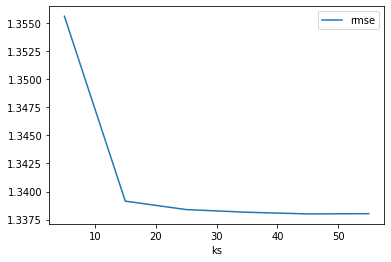

In [20]:
# # run this may take 2527.366 seconds
# # the result of this process:
# # optimal k (nearest neighbors): 3   35.0


t0 = time.time()
df_pred_results = pd.DataFrame(columns= ["ks", "sample_size", "rmse", "mae"])
sample_sizes = [len(valid_df)]
ks = [5, 15, 25, 35, 45, 55]

for sample_size in sample_sizes:
    for k in ks:
        valid = CB_NLP_predict(train_df, valid_df.sample(n = sample_size, random_state = 12), df_sim, k)
        rmse = mean_squared_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)**0.5
        mae =  mean_absolute_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)**0.5
        df_pred_results = df_pred_results.append({"ks": k, "sample_size": sample_size,
                                                  "rmse": rmse, "mae": mae}, ignore_index = True)
t1 = time.time()
print("time elapsed: (seconds)")
print(np.round(t1 - t0,3))

df_pred_results[df_pred_results["sample_size"] == sample_size].plot("ks", "rmse")
print("optimal k (nearest neighbors):")
print(df_pred_results.loc[df_pred_results["rmse"] == np.min(df_pred_results.rmse),])

# df_pred_results.to_csv("Content_Based_Filtering_Cosine_Evaluation.csv",index = False)

In [22]:
df_pred_results.to_csv("Content_Based_Filtering_Cosine_Evaluation2.csv",index = False)

optimal k (nearest neighbors):
     ks  sample_size      rmse       mae
4  45.0      19500.0  1.338007  1.004968


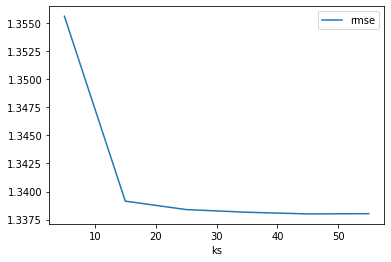

In [119]:
df_pred_results[df_pred_results["sample_size"] == sample_size].plot("ks", "rmse")
print("optimal k (nearest neighbors):")
print(df_pred_results.loc[df_pred_results["rmse"] == np.min(df_pred_results.rmse),])



In [170]:
np.round(df_pred_results["rmse"]**2,10)

0    1.837703
1    1.793311
2    1.791299
3    1.790662
4    1.790263
5    1.790323
Name: rmse, dtype: float64

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'k')

Text(0, 0.5, 'MSE')

Text(0.5, 1.0, 'Content Based Model (Tf-idf): k vs MSE')

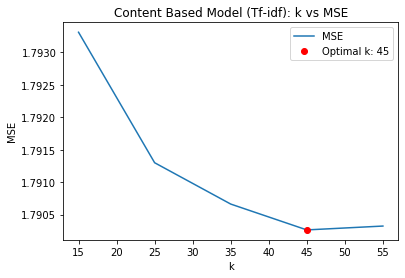

In [171]:
optimal = df_pred_results.loc[df_pred_results["rmse"] == np.min(df_pred_results.rmse),]
plt.figure()
plt.plot(df_pred_results["ks"][1:], np.round(df_pred_results["rmse"]**2,10)[1:10], label = "MSE")
plt.plot(optimal["ks"], np.round(optimal["rmse"]**2,10), "ro", label = "Optimal k: {}".format(45))
plt.legend()
plt.xlabel("k")
plt.ylabel("MSE")
plt.title("Content Based Model (Tf-idf): k vs MSE")

## LSI Model

### - 2 parameters to tune: n topics and k nearest businesses

In [16]:
def get_lsi(processed, reviews, user_id, n_topics):
    '''
    get the lsi model for user_id
    '''
    user_bids = reviews[reviews['user_id']==user_id]['business_id'].values
    processed_user = processed.loc[processed.business_id.isin(user_bids)]
    documents = list(processed_user['text'].values)
    texts = [[word for word in document.split(' ')] for document in documents]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts] 

    lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=n_topics)
    
    return lsi, dictionary, corpus

In [ ]:
# #### Dont run this cell !!!

# df_lsi = pd.DataFrame(columns = ["user_id","n_topic", "lsi", "dictionary"])
# n_topics = [10,20,50,80,100,150]

# for n_topic in n_topics:
#     for i in range(len(test_df)):
#         lsi, dictionary, corpus = get_lsi(df_texts_train, train_df, user_id_sample[i], n_topic)
#         df_lsi = df_lsi.append({"user_id": test_df.user_id[i],
#                                 "n_topic": n_topic,
#                                 "lsi": lsi,
#                                 "dictionary": dictionary}, ignore_index = True)

In [17]:
# def get_recommendation_lsi(processed, reviews, df_lsi, business_id, user_id, k, n_topics):
#     lsi = df_lsi[(df_lsi["n_topic"] == n_topics) & (df_lsi["user_id"] == user_id)]["lsi"][0]
#     dictionary = df_lsi[(df_lsi["n_topic"] == n_topics) & (df_lsi["user_id"] == user_id)]["dictionary"][0]
#     user_bids = reviews[reviews['user_id']==user_id]['business_id'].values
#     processed_user = processed.loc[processed.business_id.isin(user_bids)]
#     documents = list(processed_user['text'].values)
#     texts = [[word for word in document.split(' ')] for document in documents]
#     corpus = [dictionary.doc2bow(text) for text in texts] 
    
#     doc = processed['text'].loc[processed.business_id==business_id].values[0]
#     vec_bow = dictionary.doc2bow(doc.lower().split())
#     vec_lsi = lsi[vec_bow]
#     index = similarities.MatrixSimilarity(lsi[corpus])
#     sims = list(index[vec_lsi])
#     results = list(zip(user_bids, sims))
#     results_ordered = np.array(sorted(results, key=lambda x: x[1], reverse=True))
#     results_topk = results_ordered[:k]
    
#     return results_topk[:,0]

# def get_results_lsi(processed,reviews,reviews_test, df_lsi ,business_id,user_id,k,n_topics):
#     actual = reviews_test.loc[(reviews_test.user_id==user_id) & (reviews_test.business_id==business_id)]['stars'].values[0]
#     business_ids = get_recommendation_lsi(processed,reviews,df_lsi ,business_id,user_id,k,n_topics)
#     prediction = predict_rating(reviews, user_id, business_ids)
    
#     return actual, prediction

In [18]:
def get_recommendation_lsi(processed,reviews,business_id,user_id,k,n_topics):
    user_bids = reviews[reviews['user_id']==user_id]['business_id'].values
    processed_user = processed.loc[processed.business_id.isin(user_bids)]
    documents = list(processed_user['text'].values)
    texts = [[word for word in document.split(' ')] for document in documents]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts] 

    lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=n_topics)
    doc = processed['text'].loc[processed.business_id==business_id].values[0]
    vec_bow = dictionary.doc2bow(doc.lower().split())
    vec_lsi = lsi[vec_bow]
    index = similarities.MatrixSimilarity(lsi[corpus])
    sims = list(index[vec_lsi])
    results = list(zip(user_bids, sims))
    results_ordered = np.array(sorted(results, key=lambda x: x[1], reverse=True))
    results_topk = results_ordered[:k]
    
    return results_topk[:,0]

def get_results_lsi(processed,reviews,reviews_test ,business_id,user_id,k,n_topics):
    actual = reviews_test.loc[(reviews_test.user_id==user_id) & (reviews_test.business_id==business_id)]['stars'].values[0]
    business_ids = get_recommendation_lsi(processed,reviews,business_id,user_id,k,n_topics)
    prediction = predict_rating(reviews, user_id, business_ids)
    return actual, prediction

def CB_LSI_predict(df_texts_train, reviews, reviews_test, k = 5, n_topics = 100):
    uid_sample = reviews_test['user_id'].values
    bid_sample = reviews_test['business_id'].values
    actual_lsi = []
    predictions_lsi = []
    for i in range(len(reviews_test)):
        try:
            act, pred = get_results_lsi(df_texts_train, reviews, reviews_test, bid_sample[i],uid_sample[i], k, n_topics)
            predictions_lsi.append(pred)
            actual_lsi.append(act)

        except:
            predictions_lsi.append(np.nan)
            actual_lsi.append(np.nan)
            
    return pd.DataFrame({"user_id": uid_sample,
                         "business_id": bid_sample,
                         "ratings": actual_lsi,
                         "pred_lsi":  predictions_lsi                       
                        })

In [ ]:
t0 = time.time()
df_pred_results_lsi = pd.DataFrame(columns= ["ks","n_topics","sample_size", "rmse", "mae"])
# sample_sizes = [100]
ks = [20,40,50]
n_topics = [20,50,80,100,120]

# for sample_size in sample_sizes:
for k in ks:
    for n_topic in n_topics:
        test = CB_LSI_predict(df_texts_train,train_df, test_df, k = k, n_topics = n_topic)
        rmse = mean_squared_error(test.dropna().pred_lsi, test.dropna().ratings)**0.5
        mae = mean_absolute_error(test.dropna().pred_lsi, test.dropna().ratings)
        df_pred_results_lsi = df_pred_results_lsi.append({"ks": k, "n_topics": n_topic,"sample_size": len(test_df),
                                "rmse": rmse, "mae": mae}, ignore_index = True)
t1=  time.time()
print("time elapsed: (seconds)")
print(np.round(t1- t0,3))

In [172]:
df_pred_results_lsi

NameError: name 'df_pred_results_lsi' is not defined

In [ ]:
df_pred_results_lsi[df_pred_results_lsi["n_topics"] == 120].plot("ks", "rmse")

In [ ]:
df_pred_results_lsi[df_pred_results_lsi["ks"] == 40].plot("n_topics", "rmse")

In [ ]:
mean_squared_error(test.dropna().pred_lsi, test.dropna().ratings)**0.5

In [ ]:
df_pred_results_lsi

In [ ]:
%timeit get_results_lsi(df_texts_train, train_df, test_df, bid_sample[0], uid_sample[0], 30,10)

In [ ]:
# experiement
uid_sample = test_df['user_id'].values
bid_sample = test_df['business_id'].values
act, pred = get_results_lsi(df_texts_train, train_df, 
                                test_df, 
                                bid_sample[0], 
                                uid_sample[0], 
                                30,
                                20)

In [ ]:
act, pred

# Content-Based Filtering (Cosine Similarity)

### This model leverages business non-reviews features to generate the similarity matrix

### Data Cleaning 

In [20]:
busi = pd.read_csv('../data/business_data_subset.csv')

In [21]:
busi.head(1)

,business_id,business_name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,CsLQLiRoafpJPJSkNX2h5Q,Middle East Deli,4508 E Independence Blvd,Charlotte,NC,28205,35.194894,-80.767442,3.0,5,0,"{'RestaurantsGoodForGroups': 'True', 'OutdoorS...","Food, Restaurants, Grocery, Middle Eastern",NaN


### Change dict attribute to dummy variables

In [22]:
def convert_dict_into_dummy(data,feature):
    """
    First change feature values from str to dict, then create variables according to dict keys.
    return: dataframe with dict keys as columns
    """
    col_index = data.columns.get_loc(feature)
    get_dict = pd.Series(data.iloc[:,col_index].replace(np.nan,"None")).apply(eval)
    dummy_df = get_dict.replace("None",np.nan).replace("nan",np.nan).apply(pd.Series)
    return dummy_df

In [23]:
attr = convert_dict_into_dummy(busi,"attributes")
attr.head(1)

,RestaurantsGoodForGroups,OutdoorSeating,BusinessAcceptsCreditCards,RestaurantsTakeOut,GoodForKids,BusinessParking,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsAttire,BikeParking,...,BYOBCorkage,CoatCheck,Corkage,BYOB,AgesAllowed,RestaurantsCounterService,DietaryRestrictions,Open24Hours,AcceptsInsurance,HairSpecializesIn
0,True,False,True,True,True,"{'garage': False, 'street': False, 'validated'...",1,False,u'casual',NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
ambience = convert_dict_into_dummy(attr,"Ambience")
ambience.head(1)

,romantic,intimate,touristy,hipster,divey,classy,trendy,upscale,casual
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# change column name
ambience.columns = ["Ambience_"+i for i in ambience.columns.tolist()]
# concat
attr = pd.concat([attr.drop(['Ambience'],1),ambience],axis=1)

### Good for Meal; late nights

In [26]:
goodformeal = convert_dict_into_dummy(attr,"GoodForMeal")
goodformeal.head(5)

,dessert,latenight,lunch,dinner,brunch,breakfast
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN


### Change dict into boolean variable

In [27]:
def convert_dict_into_boolean(data,feature,new_name):
    """
    For some features that have many nan, but still have several values,
    convert it into boolean.
    """
    col_index = data.columns.get_loc(feature)
    data[new_name] = False
    for i in range(len(data)):
        if pd.isna(data.iloc[i,col_index]):
            continue
        elif "True" in  data.iloc[i,col_index]:
            data.loc[i,new_name] = True
    
    return data

In [28]:
attr = convert_dict_into_boolean(attr,"BusinessParking","Parking")
attr = attr.drop("BusinessParking",axis=1)

attr = convert_dict_into_boolean(attr,"Music","music")
attr = attr.drop("Music",axis=1)

### hours

In [29]:
hours = convert_dict_into_dummy(busi,"hours")
hours.notnull().head()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,False,False,False,False,False,False,False
1,True,True,True,True,True,True,True
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,True,True,True,True,True,True,True


### Finally, concatenate to form final business features

In [30]:
bus_df = pd.concat([busi.drop(['attributes','hours'],1),attr,hours.notnull()],axis=1)
bus_df.head(1)

,business_id,business_name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Ambience_casual,Parking,music,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,CsLQLiRoafpJPJSkNX2h5Q,Middle East Deli,4508 E Independence Blvd,Charlotte,NC,28205,35.194894,-80.767442,3.0,5,...,NaN,False,False,False,False,False,False,False,False,False


### Data cleaning

In [31]:
def delete_u(data,feature):
    col_index = data.columns.get_loc(feature)
    values = data.iloc[:,col_index].value_counts().index
#     print(values)
    for i in values:
        if i == "None":
            data.iloc[:,col_index].replace("None",np.nan,inplace=True)
        else:
            data.iloc[:,col_index].replace(i,i.split("'")[1],inplace=True)
            # for Alcohol
            data.iloc[:,col_index].replace("none",np.nan,inplace=True)
    return data                         

In [32]:
for feature in ["RestaurantsAttire","Alcohol","NoiseLevel","Smoking","WiFi"]:
#     print(feature)
    bus_df = delete_u(bus_df,feature)

In [33]:
bus_df.head(1)

,business_id,business_name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Ambience_casual,Parking,music,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,CsLQLiRoafpJPJSkNX2h5Q,Middle East Deli,4508 E Independence Blvd,Charlotte,NC,28205,35.194894,-80.767442,3.0,5,...,NaN,False,False,False,False,False,False,False,False,False


In [34]:
bus_df["RestaurantsAttire"].value_counts()

casual    18700
dressy      647
formal       32
Name: RestaurantsAttire, dtype: int64

### Drop non-related columns

In [35]:
bus_df = bus_df.drop(["DietaryRestrictions", "BYOB", "GoodForMeal", "AgesAllowed","Open24Hours","AcceptsInsurance",
                      "HairSpecializesIn","BYOBCorkage"],axis=1)

In [36]:
bus_df = bus_df.replace('True',True)
bus_df = bus_df.replace('False',False)
bus_df = bus_df.replace('None', np.nan)
bus_df = bus_df.replace('nan', np.nan)

In [37]:
bus_df.shape

(24401, 58)

In [38]:
bus_df_subset = bus_df[bus_df.business_id.isin(rev_busi_Pho["business_id"].unique())]
bus_df_subset.shape

(1728, 58)

In [39]:
bus_df_subset.head(1)

,business_id,business_name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Ambience_casual,Parking,music,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
53,lpQziF9QCVZQRkxac1xzcw,Bonus Round,"24 W Camelback Rd, Ste DE",Phoenix,AZ,85013,33.509785,-112.075741,4.0,123,...,True,True,False,True,True,True,True,True,True,True


In [40]:
features_ind = bus_df_subset.columns.get_loc("RestaurantsGoodForGroups")
features = bus_df_subset.columns[features_ind:]
features
bus_df_subset = bus_df_subset.set_index("business_id").filter(features)

Index(['RestaurantsGoodForGroups', 'OutdoorSeating',
       'BusinessAcceptsCreditCards', 'RestaurantsTakeOut', 'GoodForKids',
       'RestaurantsPriceRange2', 'RestaurantsReservations',
       'RestaurantsAttire', 'BikeParking', 'Alcohol', 'RestaurantsDelivery',
       'HasTV', 'WiFi', 'Caters', 'NoiseLevel', 'RestaurantsTableService',
       'DriveThru', 'DogsAllowed', 'ByAppointmentOnly', 'WheelchairAccessible',
       'HappyHour', 'BusinessAcceptsBitcoin', 'BestNights', 'GoodForDancing',
       'Smoking', 'CoatCheck', 'Corkage', 'RestaurantsCounterService',
       'Ambience_romantic', 'Ambience_intimate', 'Ambience_touristy',
       'Ambience_hipster', 'Ambience_divey', 'Ambience_classy',
       'Ambience_trendy', 'Ambience_upscale', 'Ambience_casual', 'Parking',
       'music', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       'Saturday', 'Sunday'],
      dtype='object')

In [41]:
bus_df_subset.head(1)


,RestaurantsGoodForGroups,OutdoorSeating,BusinessAcceptsCreditCards,RestaurantsTakeOut,GoodForKids,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsAttire,BikeParking,Alcohol,...,Ambience_casual,Parking,music,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
business_id,,,,,,,,,,,,,,,,,,,,,
lpQziF9QCVZQRkxac1xzcw,True,False,True,True,False,2,True,casual,True,full_bar,...,True,True,False,True,True,True,True,True,True,True



### Impute Missing Values

In [42]:
bus_df_subset = bus_df_subset.fillna(False)
bus_df_subset = bus_df_subset * 1

In [43]:
bus_df_subset.head(1)

,RestaurantsGoodForGroups,OutdoorSeating,BusinessAcceptsCreditCards,RestaurantsTakeOut,GoodForKids,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsAttire,BikeParking,Alcohol,...,Ambience_casual,Parking,music,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
business_id,,,,,,,,,,,,,,,,,,,,,
lpQziF9QCVZQRkxac1xzcw,1,0,1,1,0,2,1,casual,1,full_bar,...,1,1,0,1,1,1,1,1,1,1


In [44]:
feature_dtypes = []
for i in features:
#     print(i)
    type_to_convert = type(bus_df_subset[i].iloc[0])
#     print(type_to_convert)
    bus_df_subset[i] = bus_df_subset[i].astype(type_to_convert)

In [45]:
## Drop columns that remain objects
col_index = bus_df_subset.columns[bus_df_subset.dtypes != "object"]
bus_df_subset = bus_df_subset[col_index]

In [46]:
bus_df_subset = busi[["business_id","latitude", "longitude", "stars", "review_count", "is_open"]].set_index("business_id").merge(\
                      bus_df_subset,  left_index = True, right_index = True )                                                                                                       


### Standardize non-boolean variables

In [52]:
scaler = StandardScaler()
vars_to_scale = ["latitude", "longitude", "stars","review_count"]
bus_df_subset[vars_to_scale] = scaler.fit_transform(bus_df_subset[vars_to_scale])
# bus_df_subset.to_csv("../data/business_subset_cleaned.csv")


In [28]:
bus_df_subset = pd.read_csv("../data/business_subset_cleaned.csv", index_col= "business_id")
bus_df_subset.head(1)

,latitude,longitude,stars,review_count,is_open,RestaurantsGoodForGroups,OutdoorSeating,BusinessAcceptsCreditCards,RestaurantsTakeOut,GoodForKids,...,Ambience_casual,Parking,music,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
business_id,,,,,,,,,,,,,,,,,,,,,
lpQziF9QCVZQRkxac1xzcw,-0.155783,-0.475781,0.426501,-0.446236,1,1,0,1,1,0,...,1,1,0,1,1,1,1,1,1,1


In [103]:
len(bus_df_subset.columns)

44

In [13]:
bus_df_subset.head(1)
bus_df_subset.shape

,latitude,longitude,stars,review_count,is_open,RestaurantsGoodForGroups,OutdoorSeating,BusinessAcceptsCreditCards,RestaurantsTakeOut,GoodForKids,...,Ambience_casual,Parking,music,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
business_id,,,,,,,,,,,,,,,,,,,,,
lpQziF9QCVZQRkxac1xzcw,-0.155783,-0.475781,0.426501,-0.446236,1,1,0,1,1,0,...,1,1,0,1,1,1,1,1,1,1


(1728, 44)

## Content based Filtering (Euclidean similarity)

### Calculate truncated SVD and use reduced data to calculate similarity

<BarContainer object of 44 artists>

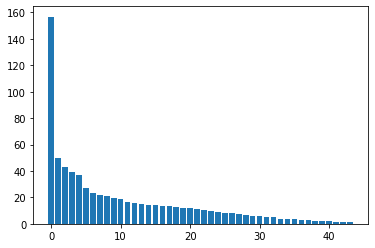

In [49]:
u, s, vt  = np.linalg.svd(bus_df_subset.iloc[:,:])
plt.bar(range(len(s)),s)
plt.show()


<BarContainer object of 44 artists>

Text(0.5, 1.0, 'Singular values of restaurant features')

Text(0.5, 0, 'Dimension')

Text(0, 0.5, 'Singular values')

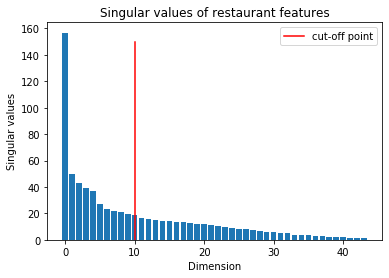

In [146]:
u, s, vt  = np.linalg.svd(bus_df_subset.iloc[:,:])
plt.bar(range(len(s)),s)
plt.plot([10 for i in np.linspace(0,150,10)], np.linspace(0,150,10),"r", label = "cut-off point")
plt.title("Singular values of restaurant features")
plt.xlabel("Dimension")
plt.ylabel("Singular values")
plt.legend(loc = "best")
plt.show()

In [149]:
np.cumsum(s**2/np.sum(s**2))[:10]

array([0.65611801, 0.72135899, 0.77086239, 0.81148973, 0.84739164,
       0.86647742, 0.88110888, 0.89351775, 0.90494873, 0.91512764])

### Choose top 10 singular values based on the above chart

In [26]:
def get_euclidean_sim(business, n_components):
    
    SVD = TruncatedSVD(n_components = n_components , random_state = 42) # 42 is the ultimate answer to everything
    bus_truncated = SVD.fit_transform(business)
    
    eucl_dist = euclidean_distances(bus_truncated)
    eucl_sim = 1/np.exp(eucl_dist)
    return eucl_sim
    
    
def get_buscosine_sim(business,n_components):
    SVD = TruncatedSVD(n_components = n_components , random_state = 42) # 42 is the ultimate answer to everything
    bus_truncated = SVD.fit_transform(business)
    
    cosine_sim = cosine_similarity(bus_truncated, bus_truncated)
    return cosine_sim

### * the two types of similarity measures yield materially different distributions, to be tested for which is better

In [29]:
eucl_sim = get_euclidean_sim(bus_df_subset, 10)
df_eucl_sim = pd.DataFrame(eucl_sim, index= bus_df_subset.index.values, columns=bus_df_subset.index.values)

bus_cos_sim = get_buscosine_sim(bus_df_subset, 10)
df_cos_sim  = pd.DataFrame(bus_cos_sim, index= bus_df_subset.index.values, columns=bus_df_subset.index.values)
bus_cos_sim.shape

(1728, 1728)

### Tuning optimal values for k (neighbors), also test the two similarity measures

time elapsed: (seconds)
4269.55


optimal k (nearest neighbors):
   ks similarity sample_size      rmse       mae
1  15        cos       19500  1.336647  1.008416


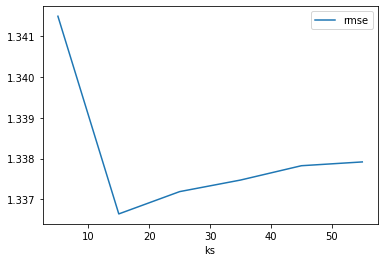

In [38]:
t0 = time.time()
df_pred_results_bus = pd.DataFrame(columns= ["ks", "similarity", "sample_size", "rmse", "mae"])
sample_sizes = [len(valid_df)]
ks = [5,15,25, 35, 45, 55]
similarity = ["cos" ]

for sim in similarity:
    if sim == "eucl":
        df_bus_sim = df_eucl_sim.copy()
    else:
        df_bus_sim = df_cos_sim.copy()
    
    for sample_size in sample_sizes:
        for k in ks:
            valid = CB_NLP_predict(train_df, valid_df.sample(n = sample_size, random_state = 12), df_bus_sim, k)
            rmse = mean_squared_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)**0.5
            mae = mean_absolute_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)
            df_pred_results_bus = df_pred_results_bus.append({"ks": k, "similarity": sim,  "sample_size": sample_size,
                                                      "rmse": rmse, "mae": mae}, ignore_index = True)
t1 = time.time()
print("time elapsed: (seconds)")
print(np.round(t1 - t0,3))

df_pred_results_bus[(df_pred_results_bus["sample_size"] == sample_size) &(df_pred_results_bus["similarity"] == "cos")].plot("ks", "rmse")
print("optimal k (nearest neighbors):")
print(df_pred_results_bus.loc[df_pred_results_bus["rmse"] == np.min(df_pred_results_bus.rmse) ,])

df_pred_results_bus.to_csv("Content_Based_Filtering_Bus_nonNLP_Evaluation.csv",index = False)

In [160]:
optimal

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'k')

Text(0, 0.5, 'MSE')

Text(0.5, 1.0, 'Content Based Model (Tf-idf): k vs MSE')

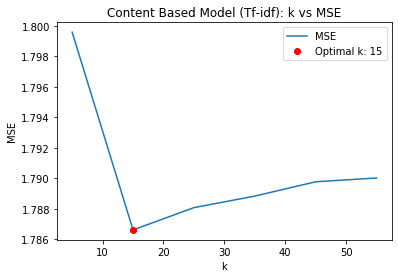

In [167]:
optimal = df_pred_results_bus.loc[df_pred_results_bus["rmse"] == np.min(df_pred_results_bus.rmse),]
plt.figure()
plt.plot(df_pred_results_bus["ks"], df_pred_results_bus["rmse"]**2, label = "MSE")
plt.plot(optimal["ks"], optimal["rmse"]**2, "ro", label = "Optimal k: {}".format(15))
plt.legend()
plt.xlabel("k")
plt.ylabel("MSE")
plt.title("Content Based Model (Tf-idf): k vs MSE")

In [478]:
## the optimal parameter is k = 15, sim = cos

30000

In [41]:
df_pred_results_bus = pd.read_csv("Content_Based_Filtering_Bus_nonNLP_Evaluation.csv")
df_pred_results_bus

,ks,similarity,sample_size,rmse,mae
0,5,cos,19500,1.341487,1.005257
1,15,cos,19500,1.336647,1.008416
2,25,cos,19500,1.337193,1.008973
3,35,cos,19500,1.337476,1.009342
4,45,cos,19500,1.337827,1.009672
5,55,cos,19500,1.337920,1.009770


# Mixture Model

- Add additional similarity matrix on top of the cosine similarity matrix

- Extracte additional information for the business dataset

- Compute the similarity between different businesses based on the numerical variables available in the business dataset. For example, stars, review_count etc.

- The new matrix is a linear combination of the cosine similarity matrix and the additional matrix, with both matrices multiplied by a factor $\lambda$ and $1-\lambda$

- The next step would be finding out the optimal value of $\lambda$, which is defaulted as 0.5

In [43]:
def get_mix_sim_matrix(cosine_sim, bus_cos_sim, lmbda = 0.5, ):
    mixed_sim = np.add(cosine_sim*lmbda, bus_cos_sim*(1-lmbda)) # assume equally weighted

    return mixed_sim

def get_mix_sim_df(df_tfidf_sim, df_bus_sim, lmbda = 0.5):
    df_tfidf_pivot = pd.melt(df_tfidf_sim.reset_index(), id_vars = "index" , value_vars = df_tfidf_sim.columns.values)
    df_bus_pivot = pd.melt(df_bus_sim.reset_index(), id_vars = "index" , value_vars = df_bus_sim.columns.values)
    
    df_merge = pd.merge(df_tfidf_pivot, df_bus_pivot, on = ["index", "variable"])
    df_merge["value"] = (lmbda) * df_merge["value_x"] + (1-lmbda) * df_merge["value_y"]
    
    df_mixed_sim = pd.pivot(df_merge, index="index", columns="variable", values ="value")
    return df_mixed_sim

In [22]:
# mixed_sim = get_mix_sim_matrix(cosine_sim,bus_cos_sim , 0.5)
# mixed_sim.shape

(1728, 1728)

## Tuning $\lambda$ 

In [96]:
t0 = time.time()
df_pred_results_mixed = pd.DataFrame(columns= ["ks", "lmbda", "sample_size", "rmse", "mae"])
sample_sizes = [len(valid_df)]
lmbdas = [0.1, 0.25, 0.5, 0.75, 0.9]

for lmbda in lmbdas:
    df_mixed_sim = get_mix_sim_matrix(df_sim, df_cos_sim , lmbda)
    k = np.int(lmbda * 45 + (1-lmbda) * 15)
    print(k)
    for sample_size in sample_sizes:         
        valid = CB_NLP_predict(train_df, valid_df.sample(n = sample_size, random_state = 12), df_mixed_sim, k)
        rmse = mean_squared_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)**0.5
        mae = mean_absolute_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)
        df_pred_results_mixed = df_pred_results_mixed.append({"ks": k, "lmbda": lmbda,  "sample_size": sample_size,
                                                      "rmse": rmse, "mae": mae}, ignore_index = True)
t1 = time.time()
print("time elapsed: (seconds)")
print(np.round(t1 - t0,3))

18
22
30
37
42
time elapsed: (seconds)
3659.714


     ks  lmbda  sample_size      rmse       mae
3  37.0   0.75      19500.0  1.338139  1.010202


,ks,lmbda,sample_size,rmse,mae
0,18.0,0.10,19500.0,1.339109,1.010907
1,22.0,0.25,19500.0,1.338506,1.010376
2,30.0,0.50,19500.0,1.338230,1.010252
3,37.0,0.75,19500.0,1.338139,1.010202
4,42.0,0.90,19500.0,1.338144,1.010132


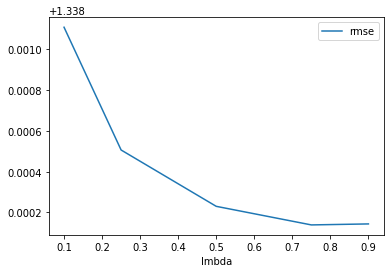

In [101]:
df_pred_results_mixed[(df_pred_results_mixed["sample_size"] == sample_size ) ].plot("lmbda", "rmse")
print(df_pred_results_mixed.loc[df_pred_results_mixed["rmse"] == np.min(df_pred_results_mixed.rmse) ,])
df_pred_results_mixed.to_csv("Content_Based_Filtering_Bus_Mixed_Evaluation.csv",index = False)
df_pred_results_mixed